In [1]:
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files
import string
import xml.etree.ElementTree as et

pd.options.display.max_columns = 999

# VEST CT 2016

## VEST Documentation

### Sources

#### Election Results
Election results from the Connecticut Secretary of State (https://portal.ct.gov/SOTS/Election-Services/Election-Results/Election-Results).

#### Shapefiles
Precinct shapefile from the U.S. Census Bureau's 2020 Redistricting Data Program.

### Processing
 
District splits not reported separately were merged for Bethel 5, Bridgeport 129-3, 130-2, Durham 3, East Haven 3-3, Hartford 11, 12, 24, Naugatuck 3-3, New Britain 12, New Haven 9-2, 17, 21-1, Stamford 3, 5, 6-1, 8, 12, 20-1, 21, Torrington 6, 7, Waterbury 74-5.

The Stratford and Westport precincts were renumbered from municipal districts to state/federal districts.

The following additional modifications were made to match the 2016 precinct boundaries.

Ansonia: Adjust 1/2 to match shapefile  
Avon: Adjust 1/3 to match street list  
Berlin: Adjust 2/5 to match voter file  
Bethel: Adjust 1/4 to match voter file  
Bridgeport: Adjust 124-2/3/4, 126-1/2/5, 130-3/4 to match PDF  
Colchester: Adjust 1/3, 2/4 to match street list  
Coventry: Adjust 1/2 to match street list  
Danbury: Align wards 4/5, 6/7 with PDF  
Darien: Align 1/5, 1/6, 2/4 with shapefile  
East Hartford: Adjust 1/2, 5/6 to match street list  
East Haven: Add 1-3, 5-3 to match street list; Align 3, 3-3 with LD  
East Windsor: Align 1, 1-2 with LD  
Enfield: Adjust 258/458 to match PDF  
Fairfield: Split 3-32/3-34 by LD; Adjust 8/9 to match PDF  
Glastonbury: Adjust 4/5, 4/9, 7/9 to match PDF  
Greenwich: Split 10/10-1 by LD; Adjust 1/2/3 to match PDF  
Guilford: Adjust 1/3, 2/3 to match descriptions  
Haddam: Adjust 1/2 to match street list  
Hamden: Adjust 1/9, 5/6 to match PDF  
Killingly: Adjust 2/4, 3/4 to match PDF  
Ledyard: Adjust 1/2 to match street list  
Litchfield: Adjust 2/4 to match voter file  
Manchester: Merge 5/9; Adjust 3/5 to match street list  
Middletown: Adjust 1/12 to match GIS  
Milford: Align 117/119, 119-1/3 with LD and PDF  
New Britain: Adjust 12/14 to match voter file  
New Haven: Split 11-1/11-3 and align VTDs with voter file  
New Milford: Align all VTDs with voter file  
Newtown: Adjust 1/2 to match street list  
Norwich: Adjust 4/5 to match voter file  
Plainfield: Adjust 1/3, 2/4 to match voter file  
Plymouth: Split 1/2 to match registrar description  
Ridgefield: Adjust 1/2, 1/3 to match voter file  
Rocky Hill: Adjust 2/3 to match voter file  
Seymour: Adjust 1/3, 2/3 to match voter file  
Shelton: Adjust 1/4, 2/3 to match PDF, voter file  
Simsbury: Adjust all VTDs to reverse 2017 redistricting  
South Windsor: Adjust 3/5, 4/5 to match PDF  
Southbury: Align all VTDs with shapefile, street list  
Southington: Adjust 3/6, 5/8, 8/9 to match PDF  
Stafford: Adjust 1/2 to match PDF  
Stamford: Merge 1/23 and adjust 6/7 to reverse 2019 redistricting  
Stonington: Align all VTDs with shapefile  
Stratford: Split 20-1/13, 80-1/21 by LD; Align VTDs with voter file  
Vernon: Adjust 1/2, 2/3 to match PDF  
Wallingford: Adjust 2/3, 2/4, 7/8 to match voter file  
Waterbury: Align VTDs with PDF, street list, voter file  
West Haven: Adjust 1/7, 4/5/6, 8/9/10 to match voter file  
Weston: Adjust 1/2 to match voter file  
Windham: Adjust 4/6 to match street list  
Windsor: Adjust 1/3 to match street list  
Wolcott: Adjust 1/2, 1/3 to match voter file  

### Races

G16PREDCLI - Hillary Clinton (Democratic Party)  
G16PRERTRU - Donald J. Trump (Republican Party)  
G16PRELJOH - Gary Johnson (Libertarian Party)  
G16PREGSTE - Jill Stein (Green Party)  
G16PREOWRI - Write-in Votes  

G16USSDBLU - Richard Blumenthal (Democratic Party and Working Families Party (fusion candidate))  
G16USSRCAR - Dan Carter (Republican Party)  
G16USSLLIO - Richard Lion (Libertarian Party)  
G16USSGRUS - Jeffery Russell (Green Party)  
G16USSOWRI - Write-in Votes  

## Election Result Processing

### Load in VEST file

In [2]:
vest_ct_16 = gp.read_file("./raw-from-source/VEST/ct_2016/ct_2016.shp")

### Create a list of the race columns

In [3]:
data_columns = [i for i in vest_ct_16.columns if "G16" in i]

### Load the Election Results

Note: Some minor formatting was applied to the election results before uploading (deleting one column and deleting additional rows that discussed turnout)

In [4]:
election_results = pd.read_csv("./raw-from-source/Election_Results/ct-2016-statewide-voting-district-report.csv",skiprows=[0,1],index_col=0)

#Clean index
election_results.reset_index(inplace=True,drop=False)

#Filter down to the races we are interested in
election_results = election_results[election_results["OfficeName"].isin(['Presidential Electors for', 'United States Senator'])]

#Create a column with the office name and the candidate
election_results["cand_detailed"] = election_results["OfficeName"]+"-"+election_results["CandidateName"]

In [5]:
#Take a look at the candidates
election_results["cand_detailed"].unique()

#Create a dictionary of name changes to match VEST
cand_detailed_change_dict = {      
       'United States Senator-Richard BlumenthalMachine/Polling Place/EDRAbsenteeTotal':"G16USSDBLU",
       'United States Senator-Dan CarterMachine/Polling Place/EDRAbsenteeTotal':"G16USSRCAR",
       'United States Senator-Richard LionMachine/Polling Place/EDRAbsenteeTotal':"G16USSLLIO",
       'United States Senator-Jeffery RussellMachine/Polling Place/EDRAbsenteeTotal':"G16USSGRUS",
       'United States Senator-Andrew RuleMachine/Polling Place/EDRAbsenteeTotal':"G16USSOWRI",
       'United States Senator-John M. TraceskiMachine/Polling Place/EDRAbsenteeTotal':"G16USSOWRI",
       'Presidential Electors for-Clinton and KaineMachine/Polling Place/EDRAbsenteeTotal':"G16PREDCLI",
       'Presidential Electors for-Trump and PenceMachine/Polling Place/EDRAbsenteeTotal':"G16PRERTRU",
       'Presidential Electors for-Johnson and WeldMachine/Polling Place/EDRAbsenteeTotal':"G16PRELJOH",
       'Presidential Electors for-Stein and BarakaMachine/Polling Place/EDRAbsenteeTotal':"G16PREGSTE",
       'Presidential Electors for-McMullin and JohnsonMachine/Polling Place/EDRAbsenteeTotal':"G16PREOWRI",
       'Presidential Electors for-Cooper and MeyerMachine/Polling Place/EDRAbsenteeTotal':"G16PREOWRI",
       'Presidential Electors for-Castle and BradleyMachine/Polling Place/EDRAbsenteeTotal':"G16PREOWRI",
       'Presidential Electors for-Kotlikoff and LeamerMachine/Polling Place/EDRAbsenteeTotal':"G16PREOWRI",
       'Presidential Electors for-La Riva and PuryearMachine/Polling Place/EDRAbsenteeTotal':"G16PREOWRI",
       'Presidential Electors for-Evans and FitchMachine/Polling Place/EDRAbsenteeTotal':"G16PREOWRI",
       'Presidential Electors for-Wu and WuMachine/Polling Place/EDRAbsenteeTotal':"G16PREOWRI",
       'Presidential Electors for-Buchanan and WashingtonMachine/Polling Place/EDRAbsenteeTotal':"G16PREOWRI",
       'Presidential Electors for-Basiago and KinnisonMachine/Polling Place/EDRAbsenteeTotal':"G16PREOWRI",
       'Presidential Electors for-De La Fuente and SteinbergMachine/Polling Place/EDRAbsenteeTotal':"G16PREOWRI",
       'Presidential Electors for-Hoefling and SchulinMachine/Polling Place/EDRAbsenteeTotal':"G16PREOWRI",
       'Presidential Electors for-Deame and LongMachine/Polling Place/EDRAbsenteeTotal':"G16PREOWRI",
       'Presidential Electors for-Blumenthal and BlairMachine/Polling Place/EDRAbsenteeTotal':"G16PREOWRI",
       'Presidential Electors for-Smith and WhiteMachine/Polling Place/EDRAbsenteeTotal':"G16PREOWRI",
       'Presidential Electors for-Schoenke and Mitchell Jr.Machine/Polling Place/EDRAbsenteeTotal':"G16PREOWRI",
       'Presidential Electors for-Cummings and RomanoffMachine/Polling Place/EDRAbsenteeTotal':"G16PREOWRI",
       'Presidential Electors for-Skewes and LacyMachine/Polling Place/EDRAbsenteeTotal':"G16PREOWRI",
       'Presidential Electors for-Klojzy Jr. and LeMayMachine/Polling Place/EDRAbsenteeTotal':"G16PREOWRI",
       'Presidential Electors for-Maldonado and TerranovaMachine/Polling Place/EDRAbsenteeTotal':"G16PREOWRI",
       'Presidential Electors for-Fox and KushnerMachine/Polling Place/EDRAbsenteeTotal':"G16PREOWRI"  
}

#Apply the name changes
election_results["cand_detailed"] = election_results["cand_detailed"].map(cand_detailed_change_dict).fillna(election_results["cand_detailed"])


In [6]:
#Perform the pivot
pivoted_results = pd.pivot_table(election_results,index=["Polling_Place_Name","TownName"],values=["Final_Count"],aggfunc=sum,columns="cand_detailed")

#Clean the pivoted data
pivoted_results.reset_index(inplace=True,drop=False)
pivoted_results.columns = pivoted_results.columns.droplevel(0)
pivoted_results.rename(columns={1:"unique_ID"},inplace=True)
pivoted_results.columns = ['Precinct', 'Town', 'G16PREDCLI', 'G16PREGSTE', 'G16PRELJOH', 'G16PREOWRI',
       'G16PRERTRU', 'G16USSDBLU', 'G16USSGRUS', 'G16USSLLIO', 'G16USSOWRI','G16USSRCAR']
pivoted_results = pivoted_results.fillna(0)

## Statewide Totals Check

In [7]:
def statewide_totals_check(partner_df,source_df,column_list):
    """Compares the totals of two election result dataframes at the statewide total level

    Args:
      partner_df: DataFrame of election results we are comparing against
      source_df: DataFrame of election results we are comparing to
      column_list: List of races that there are votes for
 
    Returns:
      Nothing, only prints out an analysis
    """
    print("***Statewide Totals Check***")
    for race in column_list:
        if (partner_df[race].sum()- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(partner_df[race].sum()-source_df[race].sum())+" votes")
            print("\tVEST: "+str(partner_df[race].sum())+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(partner_df[race].sum()))

In [8]:
statewide_totals_check(vest_ct_16,pivoted_results,data_columns)

***Statewide Totals Check***
G16PREDCLI is equal 	VEST / RDH: 897572
G16PRERTRU is equal 	VEST / RDH: 673215
G16PRELJOH is equal 	VEST / RDH: 48676
G16PREGSTE is equal 	VEST / RDH: 22841
G16PREOWRI is equal 	VEST / RDH: 2616
G16USSDBLU is equal 	VEST / RDH: 1008714
G16USSRCAR is equal 	VEST / RDH: 552621
G16USSLLIO is equal 	VEST / RDH: 18190
G16USSGRUS is equal 	VEST / RDH: 16713
G16USSOWRI is equal 	VEST / RDH: 38


## County-by-County Totals Check

In [9]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    """Compares the totals of two election result dataframes at the county level

    Args:
      partner_df: DataFrame of election results we are comparing against
      source_df: DataFrame of election results we are comparing to
      column_list: List of races that there are votes for
      county_col: String of the column name that contains county information
      full_print: Boolean specifying whether to print out everything, including counties w/ similarities

    Returns:
      Nothing, only prints out an analysis
    """
    
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
    if (len(diff_counties)>0):
        print()
        print(diff_counties)

In [10]:
#Import a file that maps from town to FIPS
ct_crosswalk = pd.read_csv("./raw-from-source/Crosswalk/Connecticut_Towns_-_Crosswalk_with_Tax_Codes_and_FIPS_Codes.csv")

In [11]:
#For the one town with an NA value, this is the correct FIPS
ct_crosswalk = ct_crosswalk.fillna("0011")
ct_crosswalk["FIPS Code"] = ct_crosswalk["FIPS Code"].astype(str)

#Create a dictionary that will map from town to FIPS
ct_crosswalk_dict = dict(zip(ct_crosswalk["Town Name"],ct_crosswalk["FIPS Code"].str[1:4]))

#Perform the mapping
pivoted_results["COUNTYFP20"] =  pivoted_results["Town"].map(ct_crosswalk_dict).fillna(pivoted_results["Town"])

#Look at the different FIPS values to make sure it worked
pivoted_results["COUNTYFP20"].unique()

array(['015', '007', '009', '003', '001', '013', '011', '005'],
      dtype=object)

In [12]:
county_totals_check(vest_ct_16,pivoted_results,data_columns,"COUNTYFP20",full_print=False)

***Countywide Totals Check***

G16PREDCLI is equal across all counties
G16PRERTRU is equal across all counties
G16PRELJOH is equal across all counties
G16PREGSTE is equal across all counties
G16PREOWRI is equal across all counties
G16USSDBLU is equal across all counties
G16USSRCAR is equal across all counties
G16USSLLIO is equal across all counties
G16USSGRUS is equal across all counties
G16USSOWRI is equal across all counties


## Precinct-by-Precinct

In [13]:
#See if these two columns could be used as unique_IDs
print(vest_ct_16["NAME20"].value_counts(dropna=False))
print(pivoted_results["Precinct"].value_counts(dropna=False))

#For the repeated "Precinct" values, also incorporate the "Town"
pivoted_results["NAME20"] = pivoted_results["Town"]+"-"+pivoted_results["Precinct"]

#Confirm that with that change the values are now unique
print(pivoted_results["NAME20"].value_counts(dropna=False))

New Haven 021-01       1
New Haven 012-02       1
Thomaston 001-00       1
Milford 118-02         1
Bethel 005-00          1
                      ..
Milford 117-00         1
Newington 007-00       1
North Canaan 001-00    1
Norwich 004-00         1
Milford 118-04         1
Name: NAME20, Length: 743, dtype: int64
DISTRICT 1-Town Hall                             13
DISTRICT 1-Town Hall - McCarthy Room              1
DISTRICT 3-East Lyme Community Center             1
DISTRICT 6-Keigwin Middle School - District 6     1
DISTRICT 1-Roxbury Town Hall                      1
                                                 ..
DISTRICT 9-Chamberlain School                     1
DISTRICT 119-1-Orange Avenue School               1
DISTRICT 2-Camp Cochipianee                       1
DISTRICT 4-Dag Hammarskjold Middle School         1
DISTRICT 2-34-St Pius School                      1
Name: Precinct, Length: 731, dtype: int64
New Haven-DISTRICT 26-Mauro Sheridan School           1
Bridgeport-DIST

In [14]:
#Attempt to join
join_attempt_one = pd.merge(vest_ct_16,pivoted_results,on="NAME20",how="outer",validate="1:1",indicator=True)
join_attempt_one["_merge"].value_counts()

#join_attempt_one[join_attempt_one["_merge"]=="left_only"].to_csv("./vest.csv")
#join_attempt_one[join_attempt_one["_merge"]=="right_only"].to_csv("./elections.csv")

left_only     743
right_only    743
both            0
Name: _merge, dtype: int64

In [16]:
elections_vest_id_changes_dict = {'Andover-DISTRICT 1-Andover Town Hall': 'Andover 001-00', 'Ansonia-DISTRICT 1-Ward 1 Ansonia Armory': 'Ansonia 001-00', 'Ansonia-DISTRICT 2-1-Ward 2 Ansonia Armory': 'Ansonia 002-01', 'Ansonia-DISTRICT 3-1-Ward 3 Holy Rosary Church': 'Ansonia 003-01', 'Ansonia-DISTRICT 4-Ward 4 Ansonia Middle School': 'Ansonia 004-00', 'Ansonia-DISTRICT 5-Ward 5 Ansonia Middle School': 'Ansonia 005-00', 'Ansonia-DISTRICT 6-Ward 6 Prendergast School': 'Ansonia 006-00', 'Ansonia-DISTRICT 7-Ward 7 Mead School': 'Ansonia 007-00', 'Ashford-DISTRICT 1-Knowlton Memorial Hall': 'Ashford 001-00', 'Avon-DISTRICT 1-Avon High School - Gymnasium': 'Avon 001-00', 'Avon-DISTRICT 2-Firehouse Company #1': 'Avon 002-00', 'Avon-DISTRICT 3-Roaring Brook School': 'Avon 003-00', 'Barkhamsted-DISTRICT 1-Barkhamsted Elementary School': 'Barkhamsted 001-00', 'Beacon Falls-DISTRICT 1-Laurel Ledge School': 'Beacon Falls 001-00', 'Berlin-DISTRICT 1-Willard School': 'Berlin 001-00', 'Berlin-DISTRICT 2-American Legion': 'Berlin 002-00', 'Berlin-DISTRICT 3-Hubbard School': 'Berlin 003-00', 'Berlin-DISTRICT 4-Senior Center': 'Berlin 004-00', 'Berlin-DISTRICT 5-Griswold School': 'Berlin 005-00', 'Bethany-DISTRICT 1-Town Hall': 'Bethany 001-00', 'Bethel-DISTRICT 1-Bethel Municipal Center 1': 'Bethel 001-00', 'Bethel-DISTRICT 2-Stony Hill Fire House -2': 'Bethel 002-00', 'Bethel-DISTRICT 3-Frank A. Berry School - 3': 'Bethel 003-00', 'Bethel-DISTRICT 4-Bethel Municipal Center 4': 'Bethel 004-00', 'Bethel-DISTRICT 5-Frank A. Berry School - 5': 'Bethel 005-00', 'Bethlehem-DISTRICT 1-Bethlehem Town Office Building': 'Bethlehem 001-00', 'Bloomfield-DISTRICT 1-Leisure Services Gym': 'Bloomfield 001-00', 'Bloomfield-DISTRICT 2-Bloomfield High School': 'Bloomfield 002-00', 'Bloomfield-DISTRICT 3-Carmen Arace Middle School': 'Bloomfield 003-00', 'Bloomfield-DISTRICT 4-Metacomet Elementary School': 'Bloomfield 004-00', 'Bloomfield-DISTRICT 5-Laurel Elementary School': 'Bloomfield 005-00', 'Bolton-DISTRICT 1-Town Hall': 'Bolton 001-00', 'Bozrah-DISTRICT 1-Fields Memorial School': 'Bozrah 001-00', 'Branford-DISTRICT 1-Community House': 'Branford 001-00', 'Branford-DISTRICT 2-St. Therese Church Hall': 'Branford 002-00', 'Branford-DISTRICT 3-Orchard House': 'Branford 003-00', 'Branford-DISTRICT 4-Branford Fire Headquarters': 'Branford 004-00', 'Branford-DISTRICT 5-Indian Neck School': 'Branford 005-00', 'Branford-DISTRICT 6-Mary T. Murphy School': 'Branford 006-00', 'Branford-DISTRICT 7-Walsh Intermediate School': 'Branford 007-00', 'Bridgeport-DISTRICT 124-1-Beardsley School': 'Bridgeport 124-01', 'Bridgeport-DISTRICT 124-2-John F. Kennedy Campus': 'Bridgeport 124-02', 'Bridgeport-DISTRICT 124-3-Dunbar School': 'Bridgeport 124-03', 'Bridgeport-DISTRICT 124-4-Harding High School': 'Bridgeport 124-04', 'Bridgeport-DISTRICT 126-1-Beardsley School': 'Bridgeport 126-01', 'Bridgeport-DISTRICT 126-2-Hallen School': 'Bridgeport 126-02', 'Bridgeport-DISTRICT 126-3-Park City Magnet School': 'Bridgeport 126-03', 'Bridgeport-DISTRICT 126-4-Read Middle School': 'Bridgeport 126-04', 'Bridgeport-DISTRICT 126-5-Thomas Hooker School': 'Bridgeport 126-05', 'Bridgeport-DISTRICT 126-6-Wilbur Cross School': 'Bridgeport 126-06', 'Bridgeport-DISTRICT 127-1-Blackham School': 'Bridgeport 127-01', 'Bridgeport-DISTRICT 127-2-Read Middle School': 'Bridgeport 127-02', 'Bridgeport-DISTRICT 127-3-John Winthrop School': 'Bridgeport 127-03', 'Bridgeport-DISTRICT 128-1-Geraldine Johnson School': 'Bridgeport 128-01', 'Bridgeport-DISTRICT 128-2-Luis Munoz Marin School': 'Bridgeport 128-02', 'Bridgeport-DISTRICT 129-1-Black Rock School': 'Bridgeport 129-01', 'Bridgeport-DISTRICT 129-2-Madison School': 'Bridgeport 129-02', 'Bridgeport-DISTRICT 129-3-Madison School': 'Bridgeport 129-03', 'Bridgeport-DISTRICT 129-4-The Aquaculture Center': 'Bridgeport 129-04', 'Bridgeport-DISTRICT 130-1-Bassick High School': 'Bridgeport 130-01', 'Bridgeport-DISTRICT 130-2-Bassick High School': 'Bridgeport 130-02', 'Bridgeport-DISTRICT 130-3-City Hall': 'Bridgeport 130-03', 'Bridgeport-DISTRICT 130-4-Cesar Batalla School': 'Bridgeport 130-04', 'Bridgeport-DISTRICT 130-5-Barnum School': 'Bridgeport 130-05', 'Bridgewater-DISTRICT 1-Bridgewater Senior Center': 'Bridgewater 001-00', 'Bristol-DISTRICT 77-1-Edgewood School': 'Bristol 077-01', 'Bristol-DISTRICT 77-2-Northeast School': 'Bristol 077-02', 'Bristol-DISTRICT 77-3-Mountain View School': 'Bristol 077-03', 'Bristol-DISTRICT 77-4-Bristol Eastern High School': 'Bristol 077-04', 'Bristol-DISTRICT 78-1-Chippens Hill Middle School': 'Bristol 078-01', 'Bristol-DISTRICT 78-2-West Bristol School': 'Bristol 078-02', 'Bristol-DISTRICT 79-1-Southside School': 'Bristol 079-01', 'Bristol-DISTRICT 79-2-Bristol Elks Club': 'Bristol 079-02', 'Bristol-DISTRICT 79-3-Greene-Hills School': 'Bristol 079-03', 'Brookfield-DISTRICT 1-Huckleberry Hill School': 'Brookfield 001-00', 'Brookfield-DISTRICT 2-Brookfield High School': 'Brookfield 002-00', 'Brooklyn-DISTRICT 1-Brooklyn Middle School': 'Brooklyn 001-00', 'Burlington-DISTRICT 1-Town Hall': 'Burlington 001-00', 'Canaan-DISTRICT 1-Canaan Town Hall': 'Canaan 001-00', 'Canterbury-DISTRICT 1-Canterbury Town Hall': 'Canterbury 001-00', 'Canton-DISTRICT 1-Canton High School': 'Canton 001-00', 'Chaplin-DISTRICT 1-Chaplin Volunteer Fire Department': 'Chaplin 001-00', 'Cheshire-DISTRICT 1-Cheshire High School - Dist. 1': 'Cheshire 001-00', 'Cheshire-DISTRICT 2-Chapman School - Dist. 2': 'Cheshire 002-00', 'Cheshire-DISTRICT 3-Artsplace - District 3': 'Cheshire 003-00', 'Cheshire-DISTRICT 4-Norton School - Dist. 4': 'Cheshire 004-00', 'Cheshire-DISTRICT 5-Doolittle School - Dist. 5': 'Cheshire 005-00', 'Cheshire-DISTRICT 6-Highland School - Dist. 6': 'Cheshire 006-00', 'Cheshire-DISTRICT 7-Dodd Middle School - Dist. 7': 'Cheshire 007-00', 'Chester-DISTRICT 1-Chester Town Office Building': 'Chester 001-00', 'Clinton-DISTRICT 2-Andrews Memorial Town Hall': 'Clinton 002-00', 'Colchester-DISTRICT 1-Colchester Town Hall': 'Colchester 001-00', 'Colchester-DISTRICT 2-Assembly Of God Hall': 'Colchester 002-00', 'Colchester-DISTRICT 3-Bacon Academy': 'Colchester 003-00', 'Colchester-DISTRICT 4-Assembly Of God Hall': 'Colchester 004-00', 'Colebrook-DISTRICT 1-Colebrook Town Hall': 'Colebrook 001-00', 'Columbia-DISTRICT 1-Horace W Porter School': 'Columbia 001-00', 'Cornwall-DISTRICT 1-Town Hall': 'Cornwall 001-00', 'Coventry-DISTRICT 1-GH Robertson School': 'Coventry 001-00', 'Coventry-DISTRICT 2-Coventry Grammer School': 'Coventry 002-00', 'Cromwell-DISTRICT 1-1-Cromwell High School': 'Cromwell 001-01', 'Danbury-DISTRICT 1-9-Danbury High School Gym': 'Danbury 001-09', 'Danbury-DISTRICT 1-10-Danbury High School Gym': 'Danbury 001-10', 'Danbury-DISTRICT 1-38-Danbury High School Gym': 'Danbury 001-38', 'Danbury-DISTRICT 2-8-Pembroke School Gym': 'Danbury 002-08', 'Danbury-DISTRICT 2-9-Pembroke School Gym': 'Danbury 002-09', 'Danbury-DISTRICT 2-38-Pembroke School Gym': 'Danbury 002-38', 'Danbury-DISTRICT 3-7-Stadley Rough School': 'Danbury 003-07', 'Danbury-DISTRICT 3-9-Stadley Rough School': 'Danbury 003-09', 'Danbury-DISTRICT 4-10-Shelter Rock School Gym': 'Danbury 004-10', 'Danbury-DISTRICT 4-9-Shelter Rock School Gym': 'Danbury 004-09', 'Danbury-DISTRICT 5-2-War Memorial Gym': 'Danbury 005-02', 'Danbury-DISTRICT 5-9-War Memorial Gym': 'Danbury 005-09', 'Danbury-DISTRICT 5-10-War Memorial Gym': 'Danbury 005-10', 'Danbury-DISTRICT 6-2-Park Avenue School Gym': 'Danbury 006-02', 'Danbury-DISTRICT 6-10-Park Avenue School Gym': 'Danbury 006-10', 'Danbury-DISTRICT 6-38-Park Avenue School Gym': 'Danbury 006-38', 'Danbury-DISTRICT 7-2-Westside Middle School Academy': 'Danbury 007-02', 'Danbury-DISTRICT 7-10-Westside Middle School Academy': 'Danbury 007-10', 'Danbury-DISTRICT 7-38-Westside Middle School Academy': 'Danbury 007-38', 'Darien-DISTRICT 1-District 1 - 35 Leroy Avenue Municipal Building': 'Darien 001-00', 'Darien-DISTRICT 2-District 2 - Darien Town Hall': 'Darien 002-00', 'Darien-DISTRICT 3-District 3 - Noroton Heights Fire Department': 'Darien 003-00', 'Darien-DISTRICT 4-District 4 - Hindley School Gymnasium Entrance': 'Darien 004-00', 'Darien-DISTRICT 5-District 5 - Darien Town Hall': 'Darien 005-00', 'Darien-DISTRICT 6-District 6 - 35 Leroy Avenue Municipal Building': 'Darien 006-00', 'Deep River-DISTRICT 1-Community Room Deep River Library': 'Deep River 001-00', 'Derby-DISTRICT 4-Irving Elementary School': 'Derby 004-00', 'Derby-DISTRICT 5-Irving School-105': 'Derby 005-00', 'Derby-DISTRICT 14-Bradley Elementary School': 'Derby 014-00', 'Durham-DISTRICT 2-Korn School 1': 'Durham 002-00', 'Durham-DISTRICT 3-Korn School 2': 'Durham 003-00', 'Durham-DISTRICT 4-Korn School 3': 'Durham 004-00', 'East Granby-DISTRICT 1-East Granby Community Center-1': 'East Granby 001-00', 'East Haddam-DISTRICT 1-Nathan Hale Ray High School': 'East Haddam 001-00', 'East Hampton-DISTRICT 1-East Hampton Middle School': 'East Hampton 001-00', 'East Hartford-DISTRICT 1-Anna Norris School': 'East Hartford 001-00', 'East Hartford-DISTRICT 2-Langford School': 'East Hartford 002-00', 'East Hartford-DISTRICT 3-Mayberry School': 'East Hartford 003-00', 'East Hartford-DISTRICT 4-Silver Lane School': 'East Hartford 004-00', 'East Hartford-DISTRICT 5-Hockanum School': 'East Hartford 005-00', 'East Hartford-DISTRICT 6-Goodwin School': 'East Hartford 006-00', 'East Hartford-DISTRICT 7-Saint Christopher Church Hall': 'East Hartford 007-00', 'East Haven-DISTRICT 1-Tuttle School 1': 'East Haven 001-00', 'East Haven-DISTRICT 1-3-East Farm Village 1-S': 'East Haven 001-03', 'East Haven-DISTRICT 2-Momauguin School 2': 'East Haven 002-00', 'East Haven-DISTRICT 3-Deer Run School 3': 'East Haven 003-00', 'East Haven-DISTRICT 3-3-Deer Run School 3-S': 'East Haven 003-03', 'East Haven-DISTRICT 4-Overbrook School 4': 'East Haven 004-00', 'East Haven-DISTRICT 5-Foxon Firehouse Clubhouse 5': 'East Haven 005-00', 'East Haven-DISTRICT 5-3-Woodview 5-S': 'East Haven 005-03', 'East Lyme-DISTRICT 1-East Lyme High School': 'East Lyme 001-00', 'East Lyme-DISTRICT 2-East Lyme Community Center': 'East Lyme 002-00', 'East Lyme-DISTRICT 3-East Lyme Community Center': 'East Lyme 003-00', 'East Windsor-DISTRICT 1-Town Hall Annex': 'East Windsor 001-00', 'East Windsor-DISTRICT 1-2-Town Hall Annex': 'East Windsor 001-02', 'East Windsor-DISTRICT 2-Town Hall': 'East Windsor 002-00', 'Eastford-DISTRICT 1-Eastford Town Hall-Lower Level': 'Eastford 001-00', 'Easton-DISTRICT 1-Samuel Staples School': 'Easton 001-00', 'Ellington-DISTRICT 1-Ellington High School': 'Ellington 001-00', 'Ellington-DISTRICT 2-Crystal Lake School': 'Ellington 002-00', 'Enfield-DISTRICT 158-J F K Middle School': 'Enfield 158-00', 'Enfield-DISTRICT 159-J F K Middle School': 'Enfield 159-00', 'Enfield-DISTRICT 258-Enfield Street School': 'Enfield 258-00', 'Enfield-DISTRICT 358-Enrico Fermi High School': 'Enfield 358-00', 'Enfield-DISTRICT 359-Enrico Fermi High School': 'Enfield 359-00', 'Enfield-DISTRICT 458-Henry Barnard School': 'Enfield 458-00', 'Enfield-DISTRICT 459-Henry Barnard School': 'Enfield 459-00', 'Essex-DISTRICT 1-Essex Town Hall 01': 'Essex 001-00', 'Fairfield-DISTRICT 1-34-Dwight School': 'Fairfield 001-34', 'Fairfield-DISTRICT 2-34-St Pius School': 'Fairfield 002-34', 'Fairfield-DISTRICT 3-32-Fairfield Woods Middle School': 'Fairfield 003-32', 'Fairfield-DISTRICT 3-34-Fairfield Woods Middle School': 'Fairfield 003-34', 'Fairfield-DISTRICT 4-33-Stratfield School': 'Fairfield 004-33', 'Fairfield-DISTRICT 5-33-Fairfield Warde High School': 'Fairfield 005-33', 'Fairfield-DISTRICT 6-33-McKinley School': 'Fairfield 006-33', 'Fairfield-DISTRICT 7-33-Holland Hill School': 'Fairfield 007-33', 'Fairfield-DISTRICT 8-32-Fairfield Ludlowe High School': 'Fairfield 008-32', 'Fairfield-DISTRICT 9-32-Sherman School': 'Fairfield 009-32', 'Fairfield-DISTRICT 10-32-Mill Hill School': 'Fairfield 010-32', 'Farmington-DISTRICT 1-1-Irving Robbins School - District 1 Precinct 1': 'Farmington 001-01', 'Farmington-DISTRICT 1-2-Irving Robbins School - District 1 Precinct 2': 'Farmington 001-02', 'Farmington-DISTRICT 1-3-Irving Robbins School - District 1 Precinct 3': 'Farmington 001-03', 'Farmington-DISTRICT 1-4-Irving Robbins School - District 1 Precinct 4': 'Farmington 001-04', 'Farmington-DISTRICT 1-5-West Woods School - District 1 Precinct 5': 'Farmington 001-05', 'Farmington-DISTRICT 2-6-Community Center - District 2 Precinct 6': 'Farmington 002-06', 'Farmington-DISTRICT 2-7-Municipal Buildngs - FHS Library Town Hall': 'Farmington 002-07', 'Franklin-DISTRICT 1-Franklin Town Hall': 'Franklin 001-00', 'Glastonbury-DISTRICT 1-District 1 - Smith Middle School': 'Glastonbury 001-00', 'Glastonbury-DISTRICT 2-Hebron Avenue School': 'Glastonbury 002-00', 'Glastonbury-DISTRICT 3-Hebron Avenue School': 'Glastonbury 003-00', 'Glastonbury-DISTRICT 4-District 4 - Gideon Welles School': 'Glastonbury 004-00', 'Glastonbury-DISTRICT 5-District 5 - Nayaug Elementary School': 'Glastonbury 005-00', 'Glastonbury-DISTRICT 7-District 7 - Academy Building': 'Glastonbury 007-00', 'Glastonbury-DISTRICT 9-District 9 - Hopewell School': 'Glastonbury 009-00', 'Goshen-DISTRICT 1-Camp Cochipianee': 'Goshen 001-00', 'Goshen-DISTRICT 2-Camp Cochipianee': 'Goshen 002-00', 'Granby-DISTRICT 1-Granby Memorial High School - Community Gym': 'Granby 001-00', 'Granby-DISTRICT 2-Granby Memorial High School - Community Gym': 'Granby 002-00', 'Greenwich-DISTRICT 1-Julian Curtiss School': 'Greenwich 001-00', 'Greenwich-DISTRICT 1-1-Julian Curtiss School 1a': 'Greenwich 001-01', 'Greenwich-DISTRICT 2-Greenwich Town Hall': 'Greenwich 002-00', 'Greenwich-DISTRICT 3-Western Middle School': 'Greenwich 003-00', 'Greenwich-DISTRICT 4-New Lebanon School': 'Greenwich 004-00', 'Greenwich-DISTRICT 4-1-New Lebanon School 4a': 'Greenwich 004-01', 'Greenwich-DISTRICT 5-Riverside School': 'Greenwich 005-00', 'Greenwich-DISTRICT 5-1-Riverside School 5a': 'Greenwich 005-01', 'Greenwich-DISTRICT 6-Old Greenwich School': 'Greenwich 006-00', 'Greenwich-DISTRICT 6-1-Old Greenwich School 6a': 'Greenwich 006-01', 'Greenwich-DISTRICT 7-Greenwich High School': 'Greenwich 007-00', 'Greenwich-DISTRICT 7-1-Greenwich High School 7a': 'Greenwich 007-01', 'Greenwich-DISTRICT 8-Central Middle School': 'Greenwich 008-00', 'Greenwich-DISTRICT 9-Bendheim Western Greenwich Civic Center': 'Greenwich 009-00', 'Greenwich-DISTRICT 10-Glenville School': 'Greenwich 010-00', 'Greenwich-DISTRICT 10-1-Glenville School': 'Greenwich 010-01', 'Greenwich-DISTRICT 11-North Street School': 'Greenwich 011-00', 'Greenwich-DISTRICT 11-1-North Street School 11a': 'Greenwich 011-01', 'Greenwich-DISTRICT 12-North Mianus School': 'Greenwich 012-00', 'Griswold-DISTRICT 1-Griswold Town Hall': 'Griswold 001-00', 'Griswold-DISTRICT 2-Pachaug Town Hall': 'Griswold 002-00', 'Groton-DISTRICT 1-Groton Public Library': 'Groton 001-00', 'Groton-DISTRICT 2-West Side Middle School': 'Groton 002-00', 'Groton-DISTRICT 3-City Of Groton Municipal Building': 'Groton 003-00', 'Groton-DISTRICT 4-Mary Morrisson Elementary School': 'Groton 004-00', 'Groton-DISTRICT 5-School Administration Bldg': 'Groton 005-00', 'Groton-DISTRICT 6-S B Butler School': 'Groton 006-00', 'Groton-DISTRICT 7-Robert E Fitch Sr High School': 'Groton 007-00', 'Guilford-DISTRICT 1-Calvin Leete School': 'Guilford 001-00', 'Guilford-DISTRICT 2-Abraham Baldwin School': 'Guilford 002-00', 'Guilford-DISTRICT 3-Guilford Fire Headquarters': 'Guilford 003-00', 'Guilford-DISTRICT 4-Melissa Jones School': 'Guilford 004-00', 'Guilford-DISTRICT 5-A.W. Cox School': 'Guilford 005-00', 'Haddam-DISTRICT 1-Haddam Firehouse Complex': 'Haddam 001-00', 'Haddam-DISTRICT 2-Central Office': 'Haddam 002-00', 'Haddam-DISTRICT 3-Haddam Neck Firehouse': 'Haddam 003-00', 'Hamden-DISTRICT 1-Miller Library': 'Hamden 001-00', 'Hamden-DISTRICT 2-Hamden Collaborative Learning Center (HCLC)': 'Hamden 002-00', 'Hamden-DISTRICT 3-Keefe Community Center': 'Hamden 003-00', 'Hamden-DISTRICT 4-Spring Glen School': 'Hamden 004-00', 'Hamden-DISTRICT 5-Board of Education Building': 'Hamden 005-00', 'Hamden-DISTRICT 5-1-Board of Education Building': 'Hamden 005-01', 'Hamden-DISTRICT 6-Ridge Hill School': 'Hamden 006-00', 'Hamden-DISTRICT 7-Dunbar Hill School': 'Hamden 007-00', 'Hamden-DISTRICT 8-Bear Path School': 'Hamden 008-00', 'Hamden-DISTRICT 8-1-Bear Path School': 'Hamden 008-01', 'Hamden-DISTRICT 9-West Woods School': 'Hamden 009-00', 'Hamden-DISTRICT 10-Hamden Middle School': 'Hamden 010-00', 'Hamden-DISTRICT 10-1-Hamden Middle School': 'Hamden 010-01', 'Hampton-DISTRICT 1-Hampton Town Offices': 'Hampton 001-00', 'Hartford-DISTRICT 1-Liberty Christian Center-Formerly Horace Bushnell': 'Hartford 001-00', 'Hartford-DISTRICT 2-Liberty Christian Center-Formerly Horace Bushnell': 'Hartford 002-00', 'Hartford-DISTRICT 3-Grace Lutheran Church': 'Hartford 003-00', 'Hartford-DISTRICT 4-Hartford Seminary': 'Hartford 004-00', 'Hartford-DISTRICT 5-United Methodist Church': 'Hartford 005-00', 'Hartford-DISTRICT 6-North End Senior Center': 'Hartford 006-00', 'Hartford-DISTRICT 7-Rawson School - Gym': 'Hartford 007-00', 'Hartford-DISTRICT 8-Annie Fisher School - Gym': 'Hartford 008-00', 'Hartford-DISTRICT 9-Y W C A': 'Hartford 009-00', 'Hartford-DISTRICT 10-House Of Restoration Church - Gym': 'Hartford 010-00', 'Hartford-DISTRICT 11-United Way Of The Capital Area': 'Hartford 011-00', 'Hartford-DISTRICT 12-Burns School - Gym': 'Hartford 012-00', 'Hartford-DISTRICT 13-Parkville Community School': 'Hartford 013-00', 'Hartford-DISTRICT 14-Environmental Sciences Magnet-Mary Hooker School': 'Hartford 014-00', 'Hartford-DISTRICT 15-Batchelder School - Gym': 'Hartford 015-00', 'Hartford-DISTRICT 16-Kennelly School - Gym': 'Hartford 016-00', 'Hartford-DISTRICT 17-South End Senior Wellness Center': 'Hartford 017-00', 'Hartford-DISTRICT 18-Metzner Center': 'Hartford 018-00', 'Hartford-DISTRICT 19-Bulkeley High School': 'Hartford 019-00', 'Hartford-DISTRICT 20-The Learning Corridor - Gym': 'Hartford 020-00', 'Hartford-DISTRICT 21-Dutch Point Community Room': 'Hartford 021-00', 'Hartford-DISTRICT 22-Hartford Public Library': 'Hartford 022-00', 'Hartford-DISTRICT 23-Mary Shepard Place Community Room': 'Hartford 023-00', 'Hartford-DISTRICT 24-Parker Memorial Community Center': 'Hartford 024-00', 'Hartland-DISTRICT 1-Hartland Town Hall': 'Hartland 001-00', 'Harwinton-DISTRICT 8-Assembly Hall': 'Harwinton 008-00', 'Harwinton-DISTRICT 31-Assembly Hall': 'Harwinton 031-00', 'Hebron-DISTRICT 1-Hebron Elementary School': 'Hebron 001-00', 'Kent-DISTRICT 1-Town Hall': 'Kent 001-00', 'Killingly-DISTRICT 1-1-Bd Of Ed Central Office - Cafeteria': 'Killingly 001-01', 'Killingly-DISTRICT 2-1-Killingly High School': 'Killingly 002-01', 'Killingly-DISTRICT 2-2-Killingly High School': 'Killingly 002-02', 'Killingly-DISTRICT 3-Bd Of Ed Central Office - Cafeteria': 'Killingly 003-00', 'Killingly-DISTRICT 4-1-Killingly High School': 'Killingly 004-01', 'Killingly-DISTRICT 4-2-Killingly High School': 'Killingly 004-02', 'Killingly-DISTRICT 5-Bd Of Ed Central Office - Cafeteria': 'Killingly 005-00', 'Killingworth-DISTRICT 1-Killingworth Elementary School': 'Killingworth 001-00', 'Lebanon-DISTRICT 1-Fire Safety Complex 1': 'Lebanon 001-00', 'Lebanon-DISTRICT 2-Fire Safety Complex 2': 'Lebanon 002-00', 'Ledyard-DISTRICT 1-Ledyard Center School': 'Ledyard 001-00', 'Ledyard-DISTRICT 2-Juliet Long School': 'Ledyard 002-00', 'Ledyard-DISTRICT 3-Juliet Long School': 'Ledyard 003-00', 'Lisbon-DISTRICT 1-Lisbon Town Hall': 'Lisbon 001-00', 'Lisbon-DISTRICT 2-Lisbon Senior Center': 'Lisbon 002-00', 'Litchfield-DISTRICT 1-Litchfield Fire House': 'Litchfield 001-00', 'Litchfield-DISTRICT 2-Northfield Fire House': 'Litchfield 002-00', 'Litchfield-DISTRICT 3-Bantam Borough Hall': 'Litchfield 003-00', 'Litchfield-DISTRICT 4-Northfield Fire House': 'Litchfield 004-00', 'Lyme-DISTRICT 1-Lyme Town Hall': 'Lyme 001-00', 'Madison-DISTRICT 1-District 1 (South)': 'Madison 001-00', 'Madison-DISTRICT 2-District 2 (North)': 'Madison 002-00', 'Manchester-DISTRICT 1-Robertson School': 'Manchester 001-00', 'Manchester-DISTRICT 2-Manchester High School': 'Manchester 002-00', 'Manchester-DISTRICT 3-Buckley School': 'Manchester 003-00', 'Manchester-DISTRICT 4-Waddell School': 'Manchester 004-00', 'Manchester-DISTRICT 5-Highland Park School': 'Manchester 005-00', 'Manchester-DISTRICT 6-Martin School': 'Manchester 006-00', 'Manchester-DISTRICT 7-Keeney School': 'Manchester 007-00', 'Manchester-DISTRICT 8-Verplanck School': 'Manchester 008-00', 'Mansfield-DISTRICT 1-Mansfield Community Center': 'Mansfield 001-00', 'Mansfield-DISTRICT 2-Mansfield Fire Dept. #107@ Eagleville': 'Mansfield 002-00', 'Mansfield-DISTRICT 3-Mansfield Library/ Buchanan Auditorium': 'Mansfield 003-00', 'Mansfield-DISTRICT 4-Annie E. Vinton School Annex': 'Mansfield 004-00', 'Marlborough-DISTRICT 1-Elmer Thienes Mary Hall Elementrary School': 'Marlborough 001-00', 'Meriden-DISTRICT 1-Immanuel Lutheran Church': 'Meriden 001-00', 'Meriden-DISTRICT 2-Community Towers': 'Meriden 002-00', 'Meriden-DISTRICT 3-John Barry School': 'Meriden 003-00', 'Meriden-DISTRICT 4-St. Rose Community Center': 'Meriden 004-00', 'Meriden-DISTRICT 5-Sherman Avenue Firehouse': 'Meriden 005-00', 'Meriden-DISTRICT 6-Washington Middle School': 'Meriden 006-00', 'Meriden-DISTRICT 7-Chamberlain Highway Firehouse': 'Meriden 007-00', 'Meriden-DISTRICT 8-New Life Church': 'Meriden 008-00', 'Meriden-DISTRICT 9-Maloney High School': 'Meriden 009-00', 'Meriden-DISTRICT 10-St. John Lutheran Church': 'Meriden 010-00', 'Meriden-DISTRICT 11-Israel Putnam School': 'Meriden 011-00', 'Meriden-DISTRICT 12-Hanover School': 'Meriden 012-00', 'Meriden-DISTRICT 13-Lincoln Middle School': 'Meriden 013-00', 'Middlebury-DISTRICT 1-Shepardson Community Center 01': 'Middlebury 001-00', 'Middlebury-DISTRICT 2-Shepardson Community Center 002': 'Middlebury 002-00', 'Middlefield-DISTRICT 100-Middlefield Community Center': 'Middlefield 100-00', 'Middletown-DISTRICT 1-Macdonough School - District 1': 'Middletown 001-00', 'Middletown-DISTRICT 2-Spencer School - District 2': 'Middletown 002-00', 'Middletown-DISTRICT 3-Keigwin Middle School - District 3': 'Middletown 003-00', 'Middletown-DISTRICT 4-Moody School - District 4': 'Middletown 004-00', 'Middletown-DISTRICT 5-Moody School - District 5': 'Middletown 005-00', 'Middletown-DISTRICT 6-Keigwin Middle School - District 6': 'Middletown 006-00', 'Middletown-DISTRICT 7-Snow School - District 7': 'Middletown 007-00', 'Middletown-DISTRICT 8-Snow School - District 8': 'Middletown 008-00', 'Middletown-DISTRICT 9-Wesley School - District 9': 'Middletown 009-00', 'Middletown-DISTRICT 10-South District Firehouse - District 10': 'Middletown 010-00', 'Middletown-DISTRICT 11-Woodrow Wilson Middle School - District 11': 'Middletown 011-00', 'Middletown-DISTRICT 12-Woodrow Wilson Middle School - District 12': 'Middletown 012-00', 'Middletown-DISTRICT 13-Spencer School - District 13': 'Middletown 013-00', 'Middletown-DISTRICT 14-Fayerweather Beckham Hall - District 14': 'Middletown 014-00', 'Milford-DISTRICT 117-Joseph A Foran High School': 'Milford 117-00', 'Milford-DISTRICT 118-1-John F Kennedy School': 'Milford 118-01', 'Milford-DISTRICT 118-2-Meadowside School': 'Milford 118-02', 'Milford-DISTRICT 118-3-West Shore Recreation Center': 'Milford 118-03', 'Milford-DISTRICT 118-4-Margaret S Egan Center': 'Milford 118-04', 'Milford-DISTRICT 118-5-Harborside Middle School': 'Milford 118-05', 'Milford-DISTRICT 119-1-Orange Avenue School': 'Milford 119-01', 'Milford-DISTRICT 119-2-John F Kennedy School': 'Milford 119-02', 'Milford-DISTRICT 119-3-Harborside Middle School': 'Milford 119-03', 'Monroe-DISTRICT 1-Fawn Hollow School': 'Monroe 001-00', 'Monroe-DISTRICT 2-Stepney Elementary School': 'Monroe 002-00', 'Monroe-DISTRICT 3-Monroe Elementary School': 'Monroe 003-00', 'Monroe-DISTRICT 4-Masuk High School': 'Monroe 004-00', 'Montville-DISTRICT 1-Town Hall-Gym-1': 'Montville 001-00', 'Montville-DISTRICT 2-Mohegan Elementary School': 'Montville 002-00', 'Montville-DISTRICT 3-Fair Oaks School-Gym-3': 'Montville 003-00', 'Montville-DISTRICT 4-Fair Oaks School-Gym-4': 'Montville 004-00', 'Montville-DISTRICT 5-Mohegan Elemantary School': 'Montville 005-00', 'Montville-DISTRICT 6-Town Hall-Gym-6': 'Montville 006-00', 'Morris-DISTRICT 1-Morris Community Hall': 'Morris 001-00', 'Naugatuck-DISTRICT 1-1-Cross Street School - A': 'Naugatuck 001-01', 'Naugatuck-DISTRICT 1-2-Andrew Avenue School': 'Naugatuck 001-02', 'Naugatuck-DISTRICT 1-3-Andrew Avenue School A': 'Naugatuck 001-03', 'Naugatuck-DISTRICT 2-1-Central Avenue School': 'Naugatuck 002-01', 'Naugatuck-DISTRICT 2-2-Cross Street School - B': 'Naugatuck 002-02', 'Naugatuck-DISTRICT 2-3-Maple Hill School': 'Naugatuck 002-03', 'Naugatuck-DISTRICT 3-1-Oak Terrace': 'Naugatuck 003-01', 'Naugatuck-DISTRICT 3-2-City Hill Middle School': 'Naugatuck 003-02', 'Naugatuck-DISTRICT 3-3-Western School - B': 'Naugatuck 003-03', 'New Britain-DISTRICT 1-Vance Village School': 'New Britain 001-00', 'New Britain-DISTRICT 2-New Britain High School': 'New Britain 002-00', 'New Britain-DISTRICT 3-Roosevelt Middle School': 'New Britain 003-00', 'New Britain-DISTRICT 4-Gaffney School': 'New Britain 004-00', 'New Britain-DISTRICT 5-New Britain Senior Center': 'New Britain 005-00', 'New Britain-DISTRICT 5-1-School Apartments': 'New Britain 005-01', 'New Britain-DISTRICT 5-2-Graham Apartments': 'New Britain 005-02', "New Britain-DISTRICT 6-Angelico's Restaurant": 'New Britain 006-00', 'New Britain-DISTRICT 7-Generale Ameglio Society': 'New Britain 007-00', 'New Britain-DISTRICT 8-Smalley Academy': 'New Britain 008-00', 'New Britain-DISTRICT 9-Chamberlain School': 'New Britain 009-00', 'New Britain-DISTRICT 10-St. Francis Of Assisi Church Hall': 'New Britain 010-00', 'New Britain-DISTRICT 11-Holmes Elementary School': 'New Britain 011-00', 'New Britain-DISTRICT 12-Pulaski Middle School': 'New Britain 012-00', 'New Britain-DISTRICT 13-ST. John Paul II Shool': 'New Britain 013-00', 'New Britain-DISTRICT 14-Diloreto School': 'New Britain 014-00', 'New Britain-DISTRICT 15-Slade Middle School': 'New Britain 015-00', 'New Canaan-DISTRICT 1-New Canaan High School Gym': 'New Canaan 001-00', 'New Canaan-DISTRICT 2-Saxe Middle School North': 'New Canaan 002-00', 'New Canaan-DISTRICT 3-Saxe Middle School South': 'New Canaan 003-00', 'New Fairfield-DISTRICT 1-Meeting House Hill School': 'New Fairfield 001-00', 'New Fairfield-DISTRICT 2-Co A Firehouse': 'New Fairfield 002-00', 'New Hartford-DISTRICT 1-New Hartford Town Hall': 'New Hartford 001-00', 'New Hartford-DISTRICT 2-South End Firehouse': 'New Hartford 002-00', 'New Haven-DISTRICT 1-2-Main Library': 'New Haven 001-02', 'New Haven-DISTRICT 2-2-Troup Academy': 'New Haven 002-02', 'New Haven-DISTRICT 3-1-Career High School': 'New Haven 003-01', 'New Haven-DISTRICT 3-2-Career High School02': 'New Haven 003-02', 'New Haven-DISTRICT 4-1-Truman School': 'New Haven 004-01', 'New Haven-DISTRICT 4-2-Truman School 02': 'New Haven 004-02', 'New Haven-DISTRICT 5-Firehouse Howard 01': 'New Haven 005-00', 'New Haven-DISTRICT 6-2-New Horizons School 02': 'New Haven 006-02', 'New Haven-DISTRICT 6-3-New Horizons School 03': 'New Haven 006-03', 'New Haven-DISTRICT 7-2-Hall Of Records 02': 'New Haven 007-02', 'New Haven-DISTRICT 8-1-Conte-West Schools 8-01': 'New Haven 008-01', 'New Haven-DISTRICT 8-2-Conte-West Hills School 02': 'New Haven 008-02', 'New Haven-DISTRICT 9-2-Wilbur Cross High School - Ward 9': 'New Haven 009-02', 'New Haven-DISTRICT 10-Wilbur Cross High School - Federal': 'New Haven 010-00', 'New Haven-DISTRICT 11-1-Bella Vista 11-01': 'New Haven 011-01', 'New Haven-DISTRICT 11-2-Bishop Woods School': 'New Haven 011-02', 'New Haven-DISTRICT 11-3-Eastview Terrace': 'New Haven 011-03', 'New Haven-DISTRICT 12-1-Ross/woodward': 'New Haven 012-01', 'New Haven-DISTRICT 12-2-Ross/woodward': 'New Haven 012-02', 'New Haven-DISTRICT 13-Benjamin Jepson Magnet School': 'New Haven 013-00', 'New Haven-DISTRICT 14-1-Atwater Senior Center 01': 'New Haven 014-01', 'New Haven-DISTRICT 15-1-Clinton Avenue School': 'New Haven 015-01', 'New Haven-DISTRICT 16-John S. Martinez School': 'New Haven 016-00', 'New Haven-DISTRICT 17-Firehouse Woodward': 'New Haven 017-00', 'New Haven-DISTRICT 18-Nathan Hale School': 'New Haven 018-00', 'New Haven-DISTRICT 19-1-Celentano Museum Academy': 'New Haven 019-01', 'New Haven-DISTRICT 19-2-Celentano Museum Academy': 'New Haven 019-02', 'New Haven-DISTRICT 20-2-Lincoln-Bassett School': 'New Haven 020-02', 'New Haven-DISTRICT 21-1-King-Robinson School': 'New Haven 021-01', 'New Haven-DISTRICT 22-1-Wexler Grant School': 'New Haven 022-01', 'New Haven-DISTRICT 22-2-Wexler Grant School': 'New Haven 022-02', 'New Haven-DISTRICT 23-Barnard School': 'New Haven 023-00', 'New Haven-DISTRICT 24-Firehouse Ellsworth': 'New Haven 024-00', 'New Haven-DISTRICT 25-Edgewood School': 'New Haven 025-00', 'New Haven-DISTRICT 26-Mauro Sheridan School': 'New Haven 026-00', 'New Haven-DISTRICT 27-1-Mitchell Library': 'New Haven 027-01', 'New Haven-DISTRICT 28-Hillhouse High School': 'New Haven 028-00', 'New Haven-DISTRICT 29-Beecher School': 'New Haven 029-00', 'New Haven-DISTRICT 30-1-Clarence Rogers School 01': 'New Haven 030-01', 'New Haven-DISTRICT 30-2-Old West Hills': 'New Haven 030-02', 'New London-DISTRICT 1-New London High School': 'New London 001-00', 'New London-DISTRICT 2-Harbor School': 'New London 002-00', 'New London-DISTRICT 3-Nathan Hale School': 'New London 003-00', 'New Milford-DISTRICT 1-Northville School': 'New Milford 001-00', 'New Milford-DISTRICT 2-Catherine E Lillis Building': 'New Milford 002-00', 'New Milford-DISTRICT 3-Odd Fellows Lodge': 'New Milford 003-00', 'New Milford-DISTRICT 4-Gaylordsville Fire House': 'New Milford 004-00', 'New Milford-DISTRICT 5-Schaghticoke School': 'New Milford 005-00', 'New Milford-DISTRICT 6-Hill & Plain School': 'New Milford 006-00', 'New Milford-DISTRICT 7-Sarah Noble Intermediate School': 'New Milford 007-00', 'Newington-DISTRICT 1-Town Hall---District---1': 'Newington 001-00', 'Newington-DISTRICT 2-Ruth L. Chaffee School---District---2': 'Newington 002-00', 'Newington-DISTRICT 3-Anna Reynolds School ---District---3': 'Newington 003-00', 'Newington-DISTRICT 4-Elizabeth Green School---District---4': 'Newington 004-00', 'Newington-DISTRICT 5-John Wallace Middle School---District---5': 'Newington 005-00', 'Newington-DISTRICT 6-John Paterson School---District---6': 'Newington 006-00', 'Newington-DISTRICT 7-Martin Kellogg Middle School---District---7': 'Newington 007-00', 'Newington-DISTRICT 8-John Wallace Middle School-- District--8': 'Newington 008-00', 'Newtown-DISTRICT 1-Middle School Gym A': 'Newtown 001-00', 'Newtown-DISTRICT 1-5-Middle School Gym A': 'Newtown 001-05', 'Newtown-DISTRICT 2-Reed Intermediate School': 'Newtown 002-00', 'Newtown-DISTRICT 3-1-Head O Meadow School Cafetorium': 'Newtown 003-01', 'Newtown-DISTRICT 3-2-Reed Intermediate School': 'Newtown 003-02', 'Newtown-DISTRICT 3-5-Head O Meadow School Cafetorium': 'Newtown 003-05', 'Norfolk-DISTRICT 1-Town Hall': 'Norfolk 001-00', 'North Branford-DISTRICT 1-Jerome Harrison Elementary School': 'North Branford 001-00', 'North Branford-DISTRICT 2-Stanley T. Williams School': 'North Branford 002-00', 'North Canaan-DISTRICT 1-Town Hall - McCarthy Room': 'North Canaan 001-00', 'North Haven-DISTRICT 1-Recreation Center': 'North Haven 001-00', 'North Haven-DISTRICT 2-Montowese Elementary School': 'North Haven 002-00', 'North Haven-DISTRICT 3-Ridge Road Elementary School': 'North Haven 003-00', 'North Haven-DISTRICT 3-11-Ridge Road Elementary School': 'North Haven 003-11', 'North Haven-DISTRICT 4-Green Acres Elementary School': 'North Haven 004-00', 'North Haven-DISTRICT 5-Clintonville Elementary School': 'North Haven 005-00', 'North Stonington-DISTRICT 1-New Town Hall': 'North Stonington 001-00', 'Norwalk-DISTRICT 137-1-Marvin School': 'Norwalk 137-01', "Norwalk-DISTRICT 137-2-St. Mary's Community Hall": 'Norwalk 137-02', 'Norwalk-DISTRICT 137-3-Tracey School': 'Norwalk 137-03', 'Norwalk-DISTRICT 140-1-Kendall School': 'Norwalk 140-01', 'Norwalk-DISTRICT 140-2-Columbus School': 'Norwalk 140-02', 'Norwalk-DISTRICT 140-3-Nathaniel Ely School': 'Norwalk 140-03', 'Norwalk-DISTRICT 141-1-Roton Middle School': 'Norwalk 141-01', 'Norwalk-DISTRICT 142-1-Fox Run School': 'Norwalk 142-01', 'Norwalk-DISTRICT 142-2-Ponus Ridge Middle School': 'Norwalk 142-02', 'Norwalk-DISTRICT 142-3-West Rocks Middle School': 'Norwalk 142-03', 'Norwalk-DISTRICT 143-1-Nathan Hale Middle School': 'Norwalk 143-01', 'Norwalk-DISTRICT 143-2-Wolfpit School': 'Norwalk 143-02', 'Norwich-DISTRICT 1-John M. Moriarty School': 'Norwich 001-00', 'Norwich-DISTRICT 2-Rose City Senior Center': 'Norwich 002-00', 'Norwich-DISTRICT 3-Samuel Huntington Elementary School': 'Norwich 003-00', 'Norwich-DISTRICT 4-John B Stanton Elementary School': 'Norwich 004-00', 'Norwich-DISTRICT 5-St Mark Lutheran Church': 'Norwich 005-00', 'Norwich-DISTRICT 6-AHEPA 110 II Apartments': 'Norwich 006-00', 'Old Lyme-DISTRICT 1-Cross Lane Firehouse': 'Old Lyme 001-00', 'Old Saybrook-DISTRICT 1-Old Saybrook Middle School Gymnasium': 'Old Saybrook 001-00', 'Old Saybrook-DISTRICT 2-Old Saybrook High School Gymnasium': 'Old Saybrook 002-00', 'Orange-DISTRICT 1-Mary L Tracy School': 'Orange 001-00', 'Orange-DISTRICT 2-High Plains Community Center': 'Orange 002-00', 'Orange-DISTRICT 3-High Plains Community Center': 'Orange 003-00', 'Oxford-DISTRICT 1-Quaker Farms School': 'Oxford 001-00', 'Plainfield-DISTRICT 1-1 Town Hall': 'Plainfield 001-00', 'Plainfield-DISTRICT 1-1-1a Town Hall': 'Plainfield 001-01', 'Plainfield-DISTRICT 2-2 Central Village Fire Station': 'Plainfield 002-00', 'Plainfield-DISTRICT 3-3 Moosup Fire Station': 'Plainfield 003-00', 'Plainfield-DISTRICT 4-4 Atwood Hose Station': 'Plainfield 004-00', 'Plainville-DISTRICT 1-Linden Street School': 'Plainville 001-00', 'Plainville-DISTRICT 2-Our Lady Of Mercy Parish Hall': 'Plainville 002-00', 'Plainville-DISTRICT 3-Toffolon School': 'Plainville 003-00', 'Plainville-DISTRICT 4-Wheeler School': 'Plainville 004-00', 'Plymouth-DISTRICT 1-H S Fisher School': 'Plymouth 001-00', 'Plymouth-DISTRICT 2-Lyceum': 'Plymouth 002-00', 'Pomfret-DISTRICT 1-Pomfret Community School': 'Pomfret 001-00', 'Portland-DISTRICT 1-Portland Middle School': 'Portland 001-00', 'Preston-DISTRICT 1-Town Hall': 'Preston 001-00', 'Prospect-DISTRICT 1-Prospect Firehouse': 'Prospect 001-00', 'Prospect-DISTRICT 2-Community School': 'Prospect 002-00', 'Putnam-DISTRICT 1-Murphy Park Building': 'Putnam 001-00', 'Putnam-DISTRICT 2-Town Garage': 'Putnam 002-00', 'Redding-DISTRICT 1-Redding Community Center': 'Redding 001-00', 'Redding-DISTRICT 2-Redding Community Center 2': 'Redding 002-00', 'Ridgefield-DISTRICT 1-East Ridge Middle School - 1': 'Ridgefield 001-00', 'Ridgefield-DISTRICT 2-Scotts Ridge Middle School - 2': 'Ridgefield 002-00', 'Ridgefield-DISTRICT 3-Yanity Gym - 3': 'Ridgefield 003-00', 'Ridgefield-DISTRICT 4-Scotts Ridge Middle School - 4': 'Ridgefield 004-00', 'Rocky Hill-DISTRICT 1-West Hill School': 'Rocky Hill 001-00', 'Rocky Hill-DISTRICT 2-Rocky Hill Community Center': 'Rocky Hill 002-00', 'Rocky Hill-DISTRICT 3-Griswold Middle School': 'Rocky Hill 003-00', 'Roxbury-DISTRICT 1-Roxbury Town Hall': 'Roxbury 001-00', 'Salem-DISTRICT 1-Salem Town Office Building': 'Salem 001-00', 'Salisbury-DISTRICT 1-Town Hall': 'Salisbury 001-00', 'Scotland-DISTRICT 1-Firehouse/community Center': 'Scotland 001-00', 'Seymour-DISTRICT 1-District 1 Community Center': 'Seymour 001-00', 'Seymour-DISTRICT 2-District 2 Seymour Middle School': 'Seymour 002-00', 'Seymour-DISTRICT 3-District 3 Chatfield-Lopresti School': 'Seymour 003-00', 'Sharon-DISTRICT 1-Sharon Town Hall': 'Sharon 001-00', 'Shelton-DISTRICT 1-Elizabeth Shelton School': 'Shelton 001-00', 'Shelton-DISTRICT 2-Shelton Intermediate School': 'Shelton 002-00', 'Shelton-DISTRICT 2-1-Shelton Intermediate School': 'Shelton 002-01', 'Shelton-DISTRICT 3-Long Hill School': 'Shelton 003-00', 'Shelton-DISTRICT 4-Mohegan School': 'Shelton 004-00', 'Sherman-DISTRICT 1-Emerg Services Facility - Firehouse- Upper Level': 'Sherman 001-00', 'Simsbury-DISTRICT 1-Henry James Memorial School': 'Simsbury 001-00', 'Simsbury-DISTRICT 2-Latimer Lane School': 'Simsbury 002-00', 'Simsbury-DISTRICT 3-Tootin Hill School': 'Simsbury 003-00', 'Simsbury-DISTRICT 4-Tariffville School': 'Simsbury 004-00', 'Somers-DISTRICT 1-Town Hall': 'Somers 001-00', 'South Windsor-DISTRICT 1-Pleasant Valley School-Gym': 'South Windsor 001-00', 'South Windsor-DISTRICT 2-Eli Terry School-Gym': 'South Windsor 002-00', 'South Windsor-DISTRICT 3-South Windsor High School-Auxiliary Gym': 'South Windsor 003-00', 'South Windsor-DISTRICT 4-Philip R. Smith School-Gym': 'South Windsor 004-00', 'South Windsor-DISTRICT 5-Timothy Edwards School - Stairwell B': 'South Windsor 005-00', 'Southbury-DISTRICT 1-Center Fire House District #1': 'Southbury 001-00', 'Southbury-DISTRICT 2-Southbury Public Library District #2': 'Southbury 002-00', 'Southbury-DISTRICT 3-Southbury Community Building District #3': 'Southbury 003-00', 'Southington-DISTRICT 1-South End School': 'Southington 001-00', 'Southington-DISTRICT 2-Kennedy School': 'Southington 002-00', 'Southington-DISTRICT 3-Derynoski School': 'Southington 003-00', 'Southington-DISTRICT 4-Hatton School': 'Southington 004-00', 'Southington-DISTRICT 5-Flanders School': 'Southington 005-00', 'Southington-DISTRICT 6-De Paolo School': 'Southington 006-00', 'Southington-DISTRICT 7-Kelley School': 'Southington 007-00', 'Southington-DISTRICT 8-Thalberg School': 'Southington 008-00', 'Southington-DISTRICT 9-Tabernacle': 'Southington 009-00', 'Southington-DISTRICT 10-Plantsville School': 'Southington 010-00', 'Southington-DISTRICT 11-Strong School': 'Southington 011-00', 'Sprague-DISTRICT 1-Baltic Fire House': 'Sprague 001-00', 'Stafford-DISTRICT 1-Benjamin A Muzio Town House': 'Stafford 001-00', 'Stafford-DISTRICT 2-Stafford Community  Center': 'Stafford 002-00', 'Stafford-DISTRICT 3-West Stafford Fire Department': 'Stafford 003-00', 'Stamford-DISTRICT 1-Our Lady Star Of The Sea': 'Stamford 001-00', 'Stamford-DISTRICT 2-Domus - The Old Rogers School': 'Stamford 002-00', 'Stamford-DISTRICT 3-Murphy School': 'Stamford 003-00', 'Stamford-DISTRICT 4-Julia A Stark School': 'Stamford 004-00', 'Stamford-DISTRICT 5-Stamford High School -Rear': 'Stamford 005-00', 'Stamford-DISTRICT 6-1-Saint Bridget Church Hall': 'Stamford 006-01', 'Stamford-DISTRICT 7-2-Agudath Sholom': 'Stamford 007-02', 'Stamford-DISTRICT 8-Stillmeadow School': 'Stamford 008-00', 'Stamford-DISTRICT 9-Salvation Army Community Center': 'Stamford 009-00', 'Stamford-DISTRICT 10-Westover School': 'Stamford 010-00', 'Stamford-DISTRICT 11-Cloonan Middle School -Side': 'Stamford 011-00', 'Stamford-DISTRICT 12-Stillmeadow School': 'Stamford 012-00', 'Stamford-DISTRICT 13-Rippowam Middle School': 'Stamford 013-00', 'Stamford-DISTRICT 14-Dolan Middle School': 'Stamford 014-00', 'Stamford-DISTRICT 15-Springdale School -Rear': 'Stamford 015-00', 'Stamford-DISTRICT 16-1-Turn Of River School': 'Stamford 016-01', 'Stamford-DISTRICT 17-Roxbury School': 'Stamford 017-00', 'Stamford-DISTRICT 18-2-Turn Of River School': 'Stamford 018-02', 'Stamford-DISTRICT 19-Davenport Ridge School': 'Stamford 019-00', 'Stamford-DISTRICT 20-1-Northeast School': 'Stamford 020-01', 'Stamford-DISTRICT 21-Scofield Middle School': 'Stamford 021-00', 'Stamford-DISTRICT 22-2-Long Ridge Church': 'Stamford 022-02', 'Sterling-DISTRICT 1-Sterling Municipal Building': 'Sterling 001-00', 'Stonington-DISTRICT 1-Stonington Fire House': 'Stonington 001-00', 'Stonington-DISTRICT 2-Pawcatuck Fire House': 'Stonington 002-00', 'Stonington-DISTRICT 3-Deans Mill School': 'Stonington 003-00', 'Stonington-DISTRICT 4-BF Hoxie Engine Company': 'Stonington 004-00', 'Stonington-DISTRICT 5-Board Of Education Administration Building': 'Stonington 005-00', 'Stratford-DISTRICT 10-1-Lordship Elementary School 120 21': 'Stratford 010-01', 'Stratford-DISTRICT 11-11-Lordship Elementary School 121 21': 'Stratford 011-11', 'Stratford-DISTRICT 20-1-Stratford High School 120 21': 'Stratford 020-01', 'Stratford-DISTRICT 20-13-Stratford High School 121 23': 'Stratford 020-13', 'Stratford-DISTRICT 20-13-Stratford High School 121-21': 'Stratford 020-11', 'Stratford-DISTRICT 30-11-Johnson House 121-21': 'Stratford 030-11', 'Stratford-DISTRICT 30-13-Johnson House 121 23': 'Stratford 030-13', 'Stratford-DISTRICT 40-11-Franklin School 121-21': 'Stratford 040-11', 'Stratford-DISTRICT 40-13-Franklin School 121 23': 'Stratford 040-13', 'Stratford-DISTRICT 50-1-Nichols School 120-21': 'Stratford 050-01', 'Stratford-DISTRICT 50-11-Nichols School 121 21': 'Stratford 050-11', 'Stratford-DISTRICT 60-1-Wooster Middle School 120 21': 'Stratford 060-01', 'Stratford-DISTRICT 60-11-Wooster Middle School 121-21': 'Stratford 060-11', 'Stratford-DISTRICT 70-1-Wilcoxson School 120 21': 'Stratford 070-01', 'Stratford-DISTRICT 80-1-Chapel Street School 120-21': 'Stratford 080-01', 'Stratford-DISTRICT 80-21-Chapel Street School 122 21': 'Stratford 080-21', 'Stratford-DISTRICT 90-1-Bunnell High School 120 21': 'Stratford 090-01', 'Stratford-DISTRICT 90-21-Bunnell High Scool 122-21': 'Stratford 090-21', 'Stratford-DISTRICT 100-1-Second Hill Lane 120 21': 'Stratford 100-01', 'Suffield-DISTRICT 1-Suffield Middle School': 'Suffield 001-00', 'Thomaston-DISTRICT 1-Lena Morton Art Gallery': 'Thomaston 001-00', 'Thompson-DISTRICT 1-Thompson Hill Fire Station': 'Thompson 001-00', 'Thompson-DISTRICT 2-Community Room Town Hall': 'Thompson 002-00', 'Thompson-DISTRICT 3-Quinebaug Volunteer Fire Department': 'Thompson 003-00', 'Thompson-DISTRICT 4-East Thompson Fire Station': 'Thompson 004-00', 'Tolland-DISTRICT 1-The Gym At Tolland Recreation Center 1': 'Tolland 001-00', 'Tolland-DISTRICT 2-Tolland Senior Center': 'Tolland 002-00', 'Tolland-DISTRICT 3-The Gym At Tolland Recreation Center 3': 'Tolland 003-00', 'Torrington-DISTRICT 1-Torrington Middle School': 'Torrington 001-00', 'Torrington-DISTRICT 2-Coe Park 1': 'Torrington 002-00', 'Torrington-DISTRICT 3-Coe Park 2': 'Torrington 003-00', 'Torrington-DISTRICT 4-Torringford School 1': 'Torrington 004-00', 'Torrington-DISTRICT 5-Torringford School 2': 'Torrington 005-00', 'Torrington-DISTRICT 6-City Hall 1': 'Torrington 006-00', 'Torrington-DISTRICT 7-City Hall 2': 'Torrington 007-00', 'Torrington-DISTRICT 8-Armory': 'Torrington 008-00', 'Trumbull-DISTRICT 1-23-Hillcrest School': 'Trumbull 001-23', 'Trumbull-DISTRICT 2-22-St. Joseph High School 122': 'Trumbull 002-22', 'Trumbull-DISTRICT 2-23-St. Joseph High School 123': 'Trumbull 002-23', 'Trumbull-DISTRICT 3-23-Madison School 123': 'Trumbull 003-23', 'Trumbull-DISTRICT 4-34-Middlebrook School 134': 'Trumbull 004-34', 'Union-DISTRICT 1-Union Town Hall': 'Union 001-00', 'Vernon-DISTRICT 1-North East School': 'Vernon 001-00', 'Vernon-DISTRICT 2-Rockville High School': 'Vernon 002-00', 'Vernon-DISTRICT 3-Skinner Road School': 'Vernon 003-00', 'Vernon-DISTRICT 4-Vernon Center Middle School': 'Vernon 004-00', 'Voluntown-DISTRICT 1-Town Hall': 'Voluntown 001-00', 'Wallingford-DISTRICT 1-Pond Hill School': 'Wallingford 001-00', 'Wallingford-DISTRICT 2-Evarts C. Stevens School': 'Wallingford 002-00', 'Wallingford-DISTRICT 3-Moses Y. Beach School': 'Wallingford 003-00', 'Wallingford-DISTRICT 4-Dag Hammarskjold Middle School': 'Wallingford 004-00', 'Wallingford-DISTRICT 5-Cook Hill School': 'Wallingford 005-00', 'Wallingford-DISTRICT 6-Parker Farms School': 'Wallingford 006-00', 'Wallingford-DISTRICT 7-Yalesville Elementary School': 'Wallingford 007-00', 'Wallingford-DISTRICT 8-Wallingford Senior Center': 'Wallingford 008-00', 'Wallingford-DISTRICT 9-Rock Hill School': 'Wallingford 009-00', 'Warren-DISTRICT 1-Town Hall': 'Warren 001-00', 'Washington-DISTRICT 1-Town Hall': 'Washington 001-00', 'Waterbury-DISTRICT 71-1-Kennedy High School': 'Waterbury 071-01', 'Waterbury-DISTRICT 71-2-Gilmartin School': 'Waterbury 071-02', 'Waterbury-DISTRICT 71-3-Tinker School': 'Waterbury 071-03', 'Waterbury-DISTRICT 72-1-Mount Olive A M E Zion Church': 'Waterbury 072-01', 'Waterbury-DISTRICT 72-2-Reed School': 'Waterbury 072-02', 'Waterbury-DISTRICT 72-3-Woodrow Wilson School': 'Waterbury 072-03', 'Waterbury-DISTRICT 72-4-Regan School': 'Waterbury 072-04', 'Waterbury-DISTRICT 72-5-Edward D Bergin Apartments': 'Waterbury 072-05', 'Waterbury-DISTRICT 73-1-Carrington School': 'Waterbury 073-01', 'Waterbury-DISTRICT 73-2-Blessed Sacrament School': 'Waterbury 073-02', 'Waterbury-DISTRICT 73-3-Kingsbury School': 'Waterbury 073-03', 'Waterbury-DISTRICT 73-4-Sprague School': 'Waterbury 073-04', 'Waterbury-DISTRICT 74-1-Chase School': 'Waterbury 074-01', 'Waterbury-DISTRICT 74-2-Crosby High School': 'Waterbury 074-02', 'Waterbury-DISTRICT 74-3-Saint Peter And Paul School': 'Waterbury 074-03', 'Waterbury-DISTRICT 74-4-Wendell Cross School 15/3': 'Waterbury 074-04', 'Waterbury-DISTRICT 74-5-Wendell Cross School 15/5': 'Waterbury 074-05', 'Waterbury-DISTRICT 75-1-Willow Plaza Community Center': 'Waterbury 075-01', 'Waterbury-DISTRICT 75-2-Washington Park House': 'Waterbury 075-02', 'Waterbury-DISTRICT 75-3-Maloney School': 'Waterbury 075-03', 'Waterbury-DISTRICT 75-4-Washington School': 'Waterbury 075-04', 'Waterford-DISTRICT 1-Town Hall': 'Waterford 001-00', 'Waterford-DISTRICT 2-Quaker Hill School': 'Waterford 002-00', 'Waterford-DISTRICT 3-Oswegatchie School': 'Waterford 003-00', 'Waterford-DISTRICT 4-Great Neck School': 'Waterford 004-00', 'Watertown-DISTRICT 1-Watertown Municipal Center': 'Watertown 001-00', 'Watertown-DISTRICT 2-Judson School': 'Watertown 002-00', 'Watertown-DISTRICT 3-Swift Middle School': 'Watertown 003-00', 'Watertown-DISTRICT 4-Polk School': 'Watertown 004-00', 'West Hartford-DISTRICT 1-King Philip Middle School': 'West Hartford 001-00', 'West Hartford-DISTRICT 2-Bristow Middle School': 'West Hartford 002-00', 'West Hartford-DISTRICT 3-West Hartford Town Hall': 'West Hartford 003-00', 'West Hartford-DISTRICT 4-Elmwood Community Center': 'West Hartford 004-00', 'West Hartford-DISTRICT 5-Wolcott School': 'West Hartford 005-00', 'West Hartford-DISTRICT 6-Conard High School': 'West Hartford 006-00', 'West Hartford-DISTRICT 7-Sedgwick Middle School': 'West Hartford 007-00', 'West Hartford-DISTRICT 8-Braeburn School': 'West Hartford 008-00', 'West Hartford-DISTRICT 9-Hall High School': 'West Hartford 009-00', 'West Haven-DISTRICT 1-City Hall': 'West Haven 001-00', 'West Haven-DISTRICT 2-Surfside Senior Housing': 'West Haven 002-00', 'West Haven-DISTRICT 3-Washington School': 'West Haven 003-00', "West Haven-DISTRICT 4-St Paul's Church Hall": 'West Haven 004-00', 'West Haven-DISTRICT 5-John Prete Senior Housing': 'West Haven 005-00', 'West Haven-DISTRICT 6-Forest School': 'West Haven 006-00', 'West Haven-DISTRICT 7-Ann V. Molloy School': 'West Haven 007-00', 'West Haven-DISTRICT 8-Mackrille School': 'West Haven 008-00', 'West Haven-DISTRICT 9-Seth Haley School': 'West Haven 009-00', 'West Haven-DISTRICT 10-Pagels School': 'West Haven 010-00', 'Westbrook-DISTRICT 1-Theresa Mulvey Municipal Center - 1': 'Westbrook 001-00', 'Westbrook-DISTRICT 2-Theresa Mulvey Municipal Center - 2': 'Westbrook 002-00', 'Weston-DISTRICT 1-Weston Middle School - 28': 'Weston 001-00', 'Weston-DISTRICT 2-Weston Middle School - 26': 'Weston 002-00', 'Westport-DISTRICT 136-1-Saugatuck Elementary School Gym': 'Westport 136-01', 'Westport-DISTRICT 136-2-Coleytown Middle School Gym': 'Westport 136-02', 'Westport-DISTRICT 136-3-Long Lots Elementary School Gym': 'Westport 136-03', 'Westport-DISTRICT 136-4-Greens Farms Elementary School Auditorium': 'Westport 136-04', 'Westport-DISTRICT 136-5-Greens Farms Elementary School Gym': 'Westport 136-05', 'Westport-DISTRICT 136-6-Westport Public Library': 'Westport 136-06', 'Westport-DISTRICT 143-1-Saugatuck Elementary School Gym': 'Westport 143-01', 'Wethersfield-DISTRICT 1-Incarnation Church Hall': 'Wethersfield 001-00', 'Wethersfield-DISTRICT 2-Keeney Cultural Center': 'Wethersfield 002-00', 'Wethersfield-DISTRICT 3-Wethersfield United Methodist Church': 'Wethersfield 003-00', 'Wethersfield-DISTRICT 4-Webb Elementary School': 'Wethersfield 004-00', 'Wethersfield-DISTRICT 5-Emerson Williams School': 'Wethersfield 005-00', 'Wethersfield-DISTRICT 6-Pitkin Community Center': 'Wethersfield 006-00', 'Willington-DISTRICT 1-The Town Office Building': 'Willington 001-00', 'Wilton-DISTRICT 1-Wilton High School - District 1': 'Wilton 001-00', 'Wilton-DISTRICT 2-Cider Mill School - District 2': 'Wilton 002-00', 'Wilton-DISTRICT 3-Middlebrook School - District 3': 'Wilton 003-00', 'Winchester-DISTRICT 1-Pearson School': 'Winchester 001-00', 'Windham-DISTRICT 4-Bpo Elks 1311': 'Windham 004-00', 'Windham-DISTRICT 5-Vfw': 'Windham 005-00', 'Windham-DISTRICT 6-Bpo Elks 1311': 'Windham 006-00', 'Windham-DISTRICT 7-Windham Center Fire Dept': 'Windham 007-00', 'Windham-DISTRICT 8-Elks': 'Windham 008-00', 'Windsor Locks-DISTRICT 1-Mario Gatti Town Hall': 'Windsor Locks 001-00', 'Windsor Locks-DISTRICT 2-Windsor Locks High School': 'Windsor Locks 002-00', 'Windsor-DISTRICT 1-L. P. Wilson': 'Windsor 001-00', 'Windsor-DISTRICT 2-John F Kennedy School': 'Windsor 002-00', 'Windsor-DISTRICT 3-330 Windsor Avenue': 'Windsor 003-00', 'Windsor-DISTRICT 4-Windsor Town Hall': 'Windsor 004-00', 'Windsor-DISTRICT 5-Oliver Ellsworth School': 'Windsor 005-00', 'Windsor-DISTRICT 6-Poquonock School': 'Windsor 006-00', 'Windsor-DISTRICT 7-Rainbow Firehouse': 'Windsor 007-00', 'Wolcott-DISTRICT 1-Tyrrell Middle School': 'Wolcott 001-00', 'Wolcott-DISTRICT 2-Wolcott High School': 'Wolcott 002-00', 'Wolcott-DISTRICT 3-Wakelee': 'Wolcott 003-00', 'Woodbridge-DISTRICT 3-Center School 3': 'Woodbridge 003-00', 'Woodbridge-DISTRICT 14-Center School 1': 'Woodbridge 014-00', 'Woodbury-DISTRICT 1-Senior/ Community Center - O&G Room': 'Woodbury 001-00', 'Woodbury-DISTRICT 2-Senior/ Community Center -- Activity Room': 'Woodbury 002-00', 'Woodstock-DISTRICT 1-Woodstock Town Hall': 'Woodstock 001-00'}

In [17]:
#Apply the name changes
pivoted_results["NAME20"] = pivoted_results["NAME20"].map(elections_vest_id_changes_dict).fillna(pivoted_results["NAME20"])

In [18]:
#Try to join again
join_attempt_two = pd.merge(vest_ct_16,pivoted_results,on="NAME20",how="outer",validate="1:1",indicator=True)
join_attempt_two["_merge"].value_counts()

#join_attempt_two[join_attempt_two["_merge"]=="left_only"].to_csv("./vest.csv")
#join_attempt_two[join_attempt_two["_merge"]=="right_only"].to_csv("./elections.csv")

both          743
left_only       0
right_only      0
Name: _merge, dtype: int64

In [19]:
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    """Checks a merged dataframe with two election results at the precinct level

    Args:
      merged_df: DataFrame with one set of election results joined to another
      column_list: List of races that there are votes for
      vest_on_left: Boolean specifying whether VEST data is on the left side of merged_df
      name_col: String of the column name to refer to precincts when a difference occurs
      print_level: Integer that specifies how large the vote difference in a precinct must be to be printed

    Returns:
      Nothing, only prints out an analysis
    """
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

In [20]:
precinct_votes_check(join_attempt_two[join_attempt_two["_merge"]=="both"],data_columns,True,"NAME20",print_level=0)


There are  743  total rows
0  of these rows have election result differences
743  of these rows are the same

The max difference between any one shared column in a row is:  0
There are  0 precinct results with a difference greater than 10

All precincts containing differences:
[]


## Shapefiles

In [21]:
#Load in the shapefiles county-by-county
file_list = []
for val in range(1,17,2):
    val_string = str(val).zfill(2)
    file_loc = "./raw-from-source/Shapefiles/partnership_shapefiles_19v2_090"+val_string+"/PVS_19_v2_vtd_090"+val_string+".shp"
    file = gp.read_file(file_loc)
    file_list.append(file)

In [22]:
#Combine into one GeoDataFrame
shapefiles = gp.GeoDataFrame(pd.concat(file_list))

<AxesSubplot:>

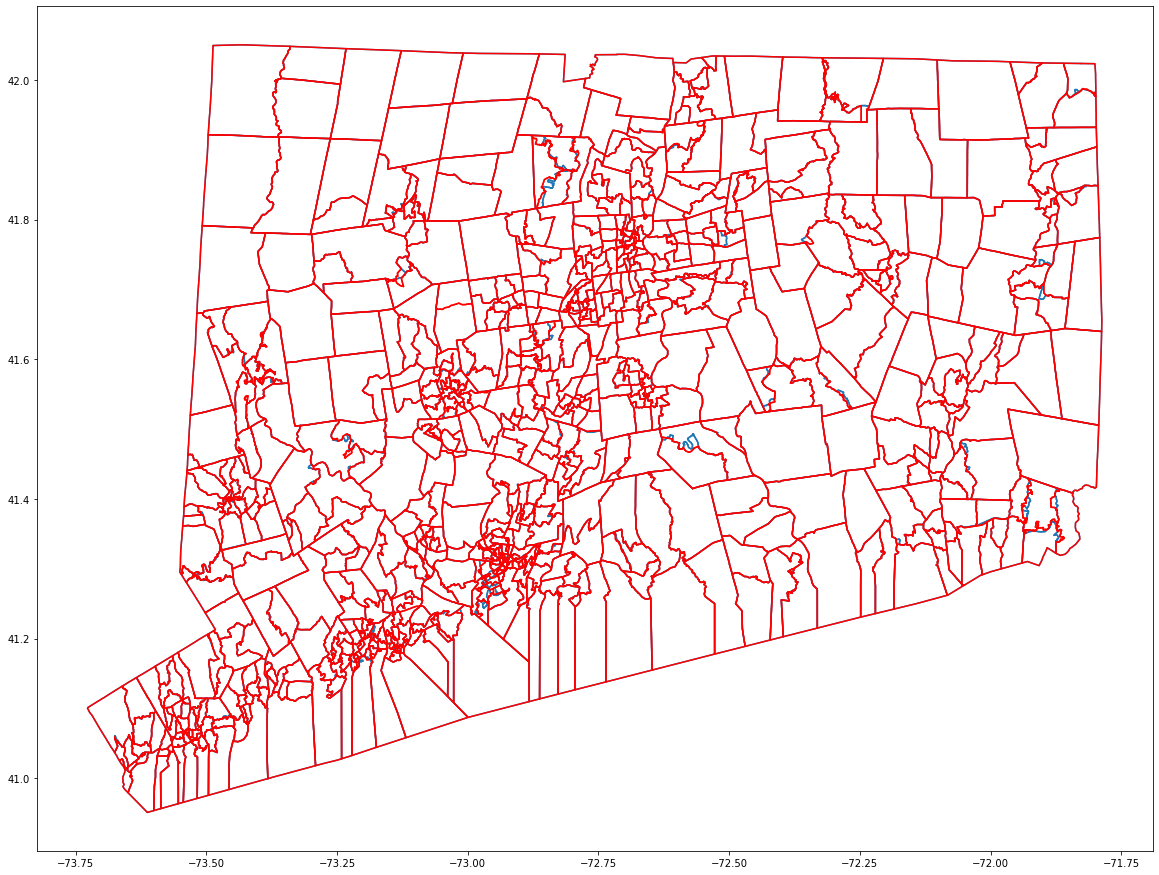

In [23]:
#Take a quick look to see how it compares with VEST's shapes
ax = shapefiles.boundary.plot(figsize=(20,20))
vest_ct_16.boundary.plot(ax=ax,color="red")